In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import glob
from pathlib import Path

from filter.RaymondFilters import RaymondFilter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from plot_tools import *

# Local import 

from spectra.py_spectra import *

# High Pass values for various values of dx - because of high pass, we want the lowpass filter cutoff to have
# a large (R~0.9) value

npass = 6

dx    = 8

klevel= [25]

filtered_W_name = "W_%2.2i" % dx

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    

def read_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def save_mfdataset_list(ds, dir, gridType=None):
    """
    Use xarray.save_mfdataset to save multiple netcdf files from a list, using the original file strings as a pattern
    """

    # Use new pathlib for Python > 3.5
    Path(dir).mkdir(parents=True, exist_ok=True)

    for n, hour in enumerate(ds.fhour):
        fcstHour  = ds.isel(fhour=n).fhour.values
        fcstStart = ds.isel(fhour=n).fcstStart
        date      = ds.isel(fhour=n).date      
        
        if gridType == None:
            gridType = ds.isel(fhour=n).attrs['gridType']
            
        outfilename = os.path.join(dir, '%s_%08d%02d_F%02d.nc' % (gridType, date, fcstStart, fcstHour))
        
        ds.isel(fhour=n).to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
    
    return


In [2]:
# Open data sets

def filter_ds(dir, output_dir, suffix, dx = 10, npass = 6, writeout=False):
    
    new_dir = "%s_%s" % (output_dir, suffix)
    
    ds  = read_mfdataset_list(dir , "region_*.nc")

    # Set up cartopy stuff here, so the plot routine is already set to use it.

    fig, axes = init_cartopy_plot(ncols=2, nrows=1, figsize=(20,10))

    # Plot the initial data

    cb_info = plot_w_from_xarray(ds, klevel=klevel, fhour=4, title='UNFILTERED', ax = axes[0])

    # Convert to numpy arrays, fill in zeros

    w = np.nan_to_num(ds.W.values).astype('float64')

    nhour, nz, ny, nx = w.shape

    w = w.reshape(nhour*nz, ny, nx)

    w_filtered = RaymondFilter(w, dx, order=6, npass = npass, highpass=True)

    ds['W'] = xr.DataArray(w_filtered.reshape(nhour,nz,ny,nx), dims = ['fhour','nz','ny','nx'])

    # Plot the Filtered data

    cb_info = plot_w_from_xarray(ds, klevel=klevel, fhour=4, title='FILTERED', ax = axes[1])

    if writeout:
        save_mfdataset_list(ds, new_dir, gridType='filtered')
    
    return


====> Begin processing runs

-------> Parameter Filter SCALE: 12 

-------> Parameter        NPASS: 6 

-------> Parameter FILTERED FILE DIRECTORY: W_12 


----> Processing run: nam for day:  2020081006 


Plot Lat Min: 34.4  Lat Max:  48.5  

Plot Lon Min: -100.5  Lon Max:  -83.7



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


RaymondFilter6F:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6F:  NPASS:  6 

NPass Loop for 3D array took 17.0059 seconds


Plot Lat Min: 34.4  Lat Max:  48.5  

Plot Lon Min: -100.5  Lon Max:  -83.7



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam_W_12/filtered_20200810600_F15.nc 


----> Processing run: nam for day:  2020070700 


Plot Lat Min: 37.8  Lat Max:  50.2  

Plot Lon Min: -106.5  Lon Max:  -90.9



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


RaymondFilter6F:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6F:  NPASS:  6 

NPass Loop for 3D array took 13.9715 seconds


Plot Lat Min: 37.8  Lat Max:  50.2  

Plot Lon Min: -106.5  Lon Max:  -90.9



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F02.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F03.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F04.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F05.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F06.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam_W_12/filtered_2020070700_F07.nc 


----> Processing run: nam for day:  2020030212 


Plot Lat Min: 28.7  Lat Max:  43.1  

Plot Lon Min: -93.7  Lon Max:  -77.0

RaymondFilter6F:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6F:  NPASS:  6 

NPass Loop for 3D array took 17.0084 seconds


Plot La

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


RaymondFilter6F:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter6F:  NPASS:  6 

NPass Loop for 3D array took 15.0207 seconds


Plot Lat Min: 31.7  Lat Max:  44.3  

Plot Lon Min: -107.5  Lon Max:  -92.2



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F09.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam_W_12/filtered_202105261200_F14.nc 


====> Ended processing runs



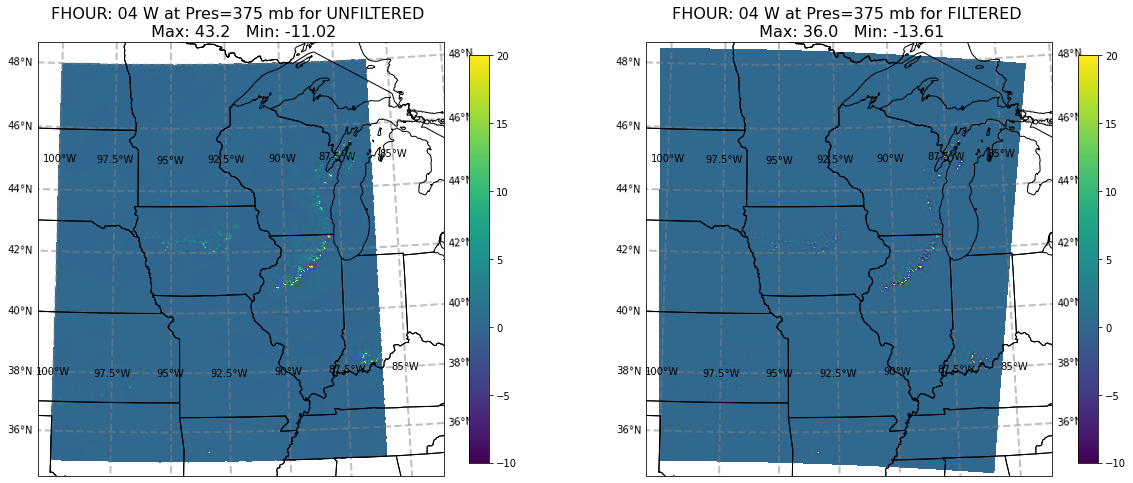

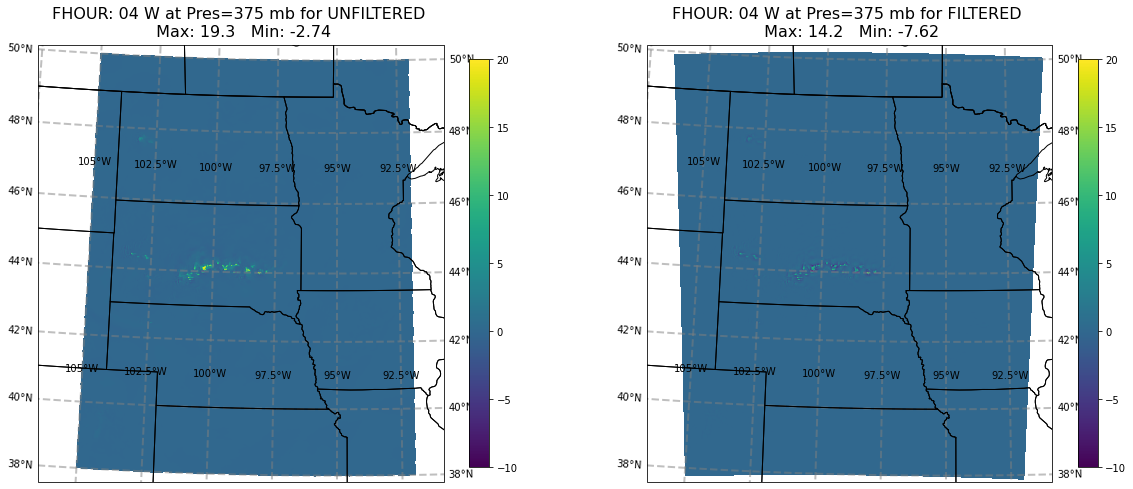

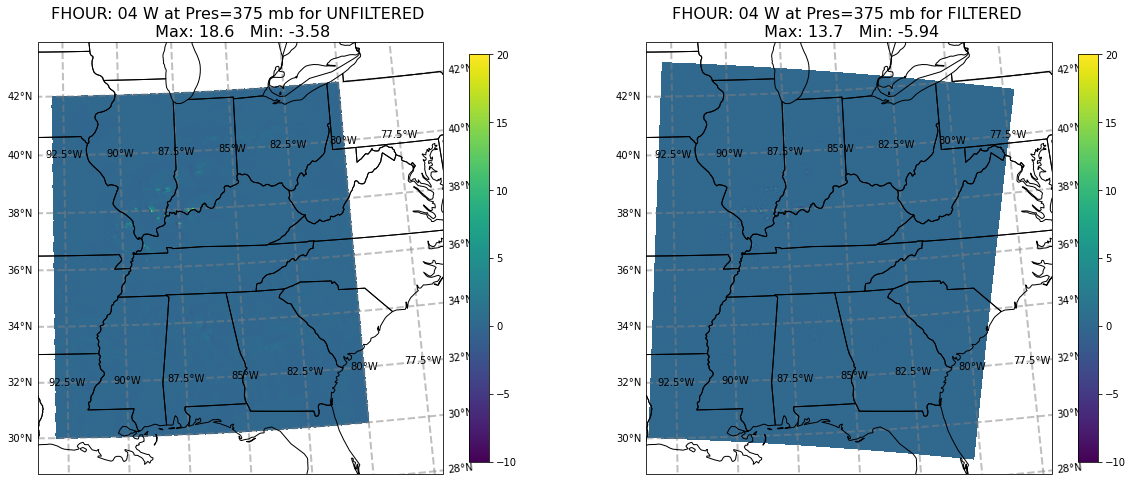

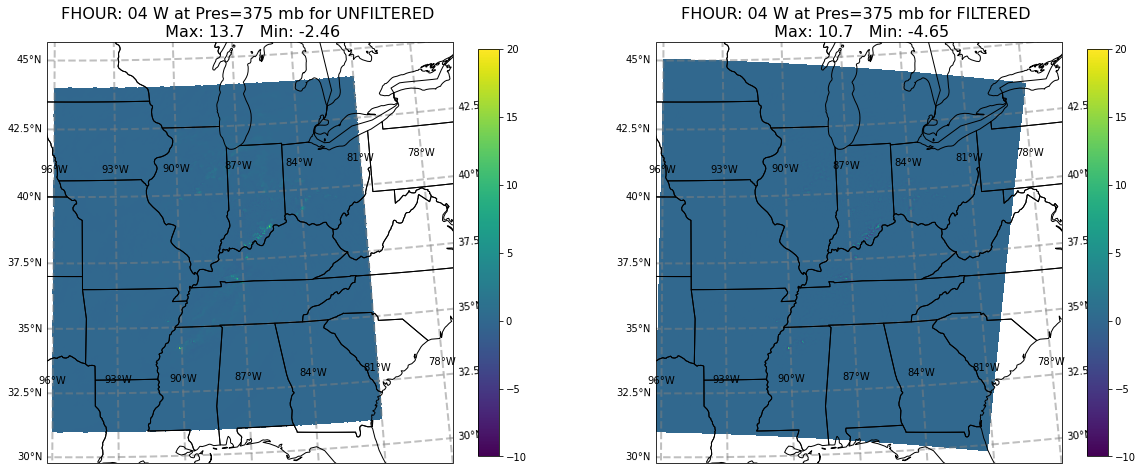

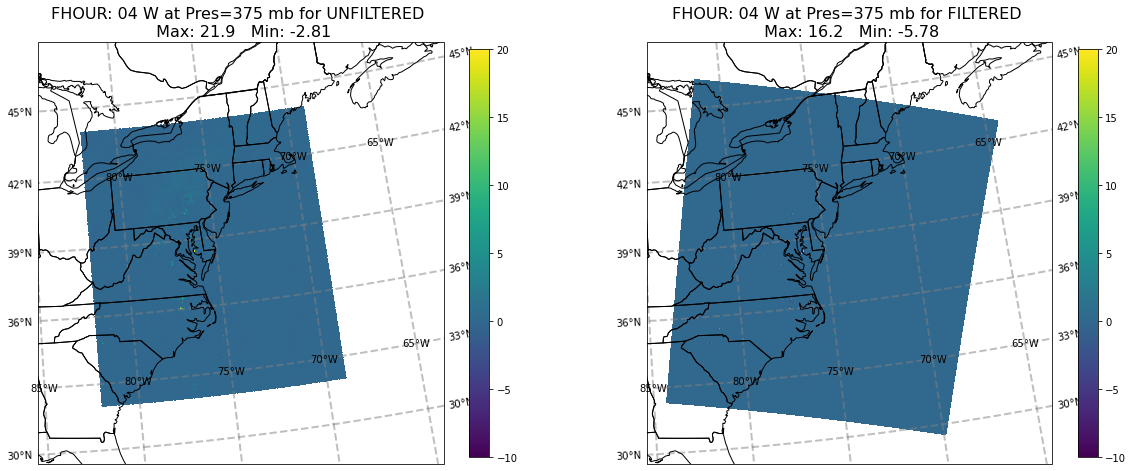

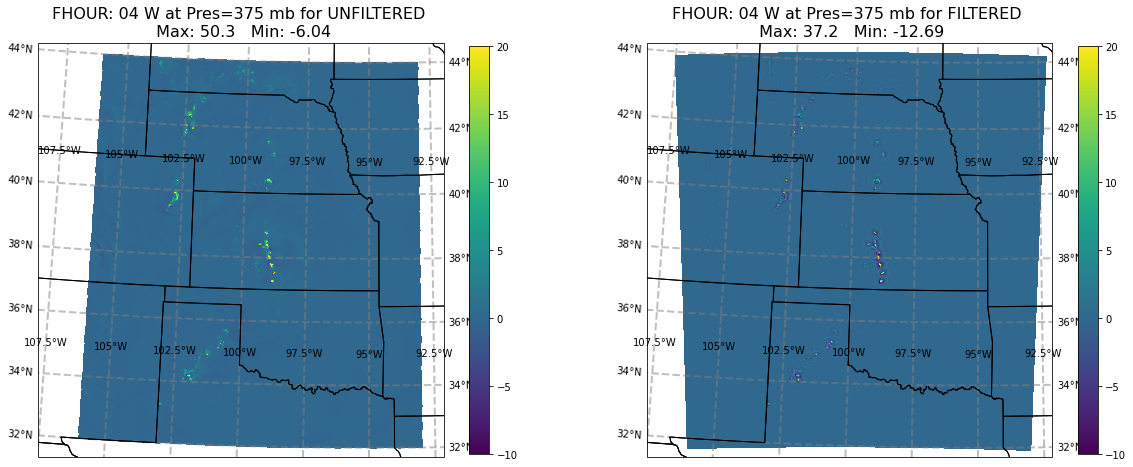

In [5]:
# Input data sets....

from input_default import input_nam as input_config

input_dir  = input_config["input_dir"]
output_dir = input_config["output_dir"]

filtered_filename = input_config["filtered_filename"]
filter_dx         = input_config["filter_dx"]
filter_npass      = input_config["filter_npass"]

if len(filtered_filename) == 0:
    filtered_filename = "W_%2.2i" % filter_dx
    
#------------------------------------------------------------------------------------
# cut and past from below here
#

print("\n====> Begin processing runs\n")

print("-------> Parameter Filter SCALE: %d \n" % filter_dx)
print("-------> Parameter        NPASS: %d \n" % filter_npass)
print("-------> Parameter FILTERED FILE DIRECTORY: %s \n" % filtered_filename)

for day in input_config["cases"]:
    for run in input_config["cases"][day]:
        
        print("\n----> Processing run: %s for day:  %s \n" % (run,day))
        run_dir = str(os.path.join(input_dir, day, run))
        out_dir = str(os.path.join(output_dir, day, run))
        filter_ds(run_dir, out_dir, filtered_filename, dx=filter_dx, npass=filter_npass, writeout=True)
        
print("\n====> Ended processing runs\n")


In [140]:
import json

with open("sample.json", "w") as outfile:
    json.dump(input_spec, outfile)
    
import yaml
with open("sample.yaml", "w") as outfile:
    yaml.dump(input_spec, outfile)

In [141]:
with open("sample.yaml", "r") as outfile:
    d = yaml.load(outfile, Loader=yaml.FullLoader)
    
print(d)

{'cases': {'2019071918': ['hrrr', 'ctrl', 'nord3'], '2020081006': ['hrrr', 'ctrl', 'nord3']}, 'input_dir': '/Users/Louis.Wicker/CAM_Case_Studies', 'output_dir': '/Users/Louis.Wicker/CAM_Case_Studies'}


In [134]:
yaml.load?

Signature: yaml.load(stream, Loader)
Docstring:
Parse the first YAML document in a stream
and produce the corresponding Python object.
File:      ~/miniconda3/envs/mypip/lib/python3.9/site-packages/yaml/__init__.py
Type:      function


In [142]:
f = ""
print(len(f))

0
